In [1]:
# Loading libraries
import os
import pandas as pd
import numpy as np
import pickle
import re
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Bill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Loading the dataset

def load_reviews(folder_path, domain_name):
    data = []
    labels = []

    for label in ['positive', 'negative']:
        file_path = os.path.join(folder_path, f"{label}.review")
        if os.path.exists(file_path):
            with open(file_path, encoding='utf-8') as file:
                reviews = file.readlines()
                data.extend(reviews)
                labels.extend([1 if label == 'positive' else 0] * len(reviews))

    return pd.DataFrame({'text': data, 'label': labels, 'category': domain_name})


def load_unlabeled(folder_path, domain_name):
    file_path = os.path.join(folder_path, "unlabeled.review")
    if os.path.exists(file_path):
        with open(file_path, encoding='utf-8') as file:
            reviews = file.readlines()
            return pd.DataFrame({'text': reviews, 'label': None, 'category': domain_name})
    return pd.DataFrame(columns=['text', 'label', 'category'])


In [4]:
# Base path
base_dir = "sorted_data_acl"

# Domains and their respective folders
domains = {
    "books": os.path.join(base_dir, "books"),
    "dvd": os.path.join(base_dir, "dvd"),
    "electronics": os.path.join(base_dir, "electronics"),
    "kitchen": os.path.join(base_dir, "kitchen_&_housewares")
}

# Load labeled data
labeled_dfs = [load_reviews(path, domain) for domain, path in domains.items()]

# Load unlabeled data
unlabeled_dfs = []
for domain, path in domains.items():
    if domain == "books":
        unlabeled_path = os.path.join(base_dir, "books.unlabeled")
    else:
        unlabeled_path = path
    unlabeled_dfs.append(load_unlabeled(unlabeled_path, domain))

# Combine all data
labeled_data = pd.concat(labeled_dfs).reset_index(drop=True)
unlabeled_data = pd.concat(unlabeled_dfs).reset_index(drop=True)

print("Labeled Data:", labeled_data.shape)
print("Unlabeled Data:", unlabeled_data.shape)

Labeled Data: (299239, 3)
Unlabeled Data: (2431195, 3)


In [5]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags, punctuation, and numbers
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and digits
    # Tokenize and remove stopwords
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    # Join words back to string
    return ' '.join(words)

## Preprocess and Clean the Labeled Data

### Train Custom Word Embeddings

In [6]:
# Clean the reviews
labeled_data['clean_text'] = labeled_data['text'].apply(clean_text)

# Remove outliers: very short or empty reviews
labeled_data = labeled_data[labeled_data['clean_text'].apply(lambda x: len(x.split()) > 3)]

# Reset index after filtering
labeled_data = labeled_data.reset_index(drop=True)

print("Cleaned and filtered labeled data:", labeled_data.shape)
labeled_data[['clean_text', 'label', 'category']].head()

Cleaned and filtered labeled data: (30534, 4)


,clean_text,label,category
0,sphere books michael crichton,1,books
1,one best crichton novels,1,books
2,sphere michael crichton excellant novel certai...,1,books
3,story revolves around man named norman johnson...,1,books
4,novel research crichton novels still lot infor...,1,books


In [7]:
# Combine all text (labeled + unlabeled)
all_reviews = pd.concat([labeled_data['clean_text'], unlabeled_data['text'].dropna().apply(clean_text)])

# Tokenize for Word2Vec training
sentences = [word_tokenize(text) for text in all_reviews]


In [8]:
# Train Word2Vec
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
w2v_model.save("Custom_Embedding/custom_w2v.model")


### Tokenization & Padding

In [9]:
# Tokenizer configuration
vocab_size = 5000
max_length = 100
oov_token = "<OOV>"

# Fit tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(labeled_data['clean_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(labeled_data['clean_text'])

# Pad sequences to ensure equal length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')


# Save tokenizer to a file
with open("sentiment_app/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [10]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=100,
    trainable=True  # Set to True if you want to fine-tune embeddings
)


### Preparing  Features and Labels

In [11]:
X = padded_sequences
y = np.array(labeled_data['label'])  # Already 0 (negative) and 1 (positive)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (30534, 100)
y shape: (30534,)


### View Tokenizer Summary

In [12]:
print("Tokenizer vocab size (words in use):", len(tokenizer.word_index))
print("Example sequence:", sequences[0])
print("Example padded:", X[0])


Tokenizer vocab size (words in use): 69815
Example sequence: [1, 8, 370, 3611]
Example padded: [   1    8  370 3611    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## Splitting the Data

In [13]:

# Step 1: Split into training + temp (80% training, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 2: Split temp into validation and test (50% of temp each = 10% of total data each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print the sizes
print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")


Train size: 24427
Validation size: 3053
Test size: 3054


## Define and Compile the CNN + LSTM Model

This hybrid model:

* CNN - Captures local patterns (like phrases "not good", "really bad")

* LSTM - Learns sequential dependencies and context

Model Architecture Summary
* Embedding Layer - Transforms word indices into dense vectors

* Conv1D Layer - Extracts local features (n-grams)

* MaxPooling1D - Reduces spatial dimension

* LSTM - Captures word dependencies

* Dense Layer - Outputs binary classification (positive/negative)

In [14]:
# Hyperparameters
embedding_dim = 100
num_filters = 64
kernel_size = 5
lstm_units = 64
dropout_rate = 0.5

model = Sequential([
    embedding_layer,  # Use pretrained Word2Vec embedding layer
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(lstm_units),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          6981600   
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

### Train the Model and Adding Checkpointing

In [15]:
# Data Generator to obtain batches of training and validation sets

# class DataGenerator(Sequence):
#     def __init__(self, X, y, batch_size=32, shuffle=True):
#         self.X = X
#         self.y = y
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.indexes = np.arange(len(self.X))
#         if self.shuffle:
#             np.random.shuffle(self.indexes)

#     def __len__(self):
#         return int(np.floor(len(self.X) / self.batch_size))

#     def __getitem__(self, index):
#         indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         batch_X = np.array([self.X[i] for i in indexes])
#         batch_y = np.array([self.y[i] for i in indexes])
#         return batch_X, batch_y

#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indexes)


In [16]:
#  Converting your entire training pipeline (train, validation, and test)
#  to use tf.data.Dataset will improve efficiency, scalability, and TensorFlow compatibility.

def create_dataset(X, y, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


batch_size = 32

train_dataset = create_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

In [17]:
# Save the best model (based on validation accuracy)
checkpoint_cb = ModelCheckpoint(
    filepath='model/best_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Stop training early if validation accuracy doesn’t improve
earlystop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# train_generator = DataGenerator(X_train, y_train, batch_size=32)
# val_generator = DataGenerator(X_val, y_val, batch_size=32)

#Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=2
)



Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.56371, saving model to model\best_model.h5
764/764 - 85s - loss: 0.6937 - accuracy: 0.5071 - val_loss: 0.6771 - val_accuracy: 0.5637 - 85s/epoch - 111ms/step
Epoch 2/15

Epoch 2: val_accuracy improved from 0.56371 to 0.59712, saving model to model\best_model.h5
764/764 - 84s - loss: 0.6797 - accuracy: 0.5713 - val_loss: 0.6631 - val_accuracy: 0.5971 - 84s/epoch - 110ms/step
Epoch 3/15

Epoch 3: val_accuracy improved from 0.59712 to 0.64297, saving model to model\best_model.h5
764/764 - 88s - loss: 0.6356 - accuracy: 0.6299 - val_loss: 0.6192 - val_accuracy: 0.6430 - 88s/epoch - 115ms/step
Epoch 4/15

Epoch 4: val_accuracy improved from 0.64297 to 0.65935, saving model to model\best_model.h5
764/764 - 86s - loss: 0.5943 - accuracy: 0.6689 - val_loss: 0.5943 - val_accuracy: 0.6594 - 86s/epoch - 112ms/step
Epoch 5/15

Epoch 5: val_accuracy improved from 0.65935 to 0.66983, saving model to model\best_model.h5
764/764 - 80s - loss: 0

### Plot Training History

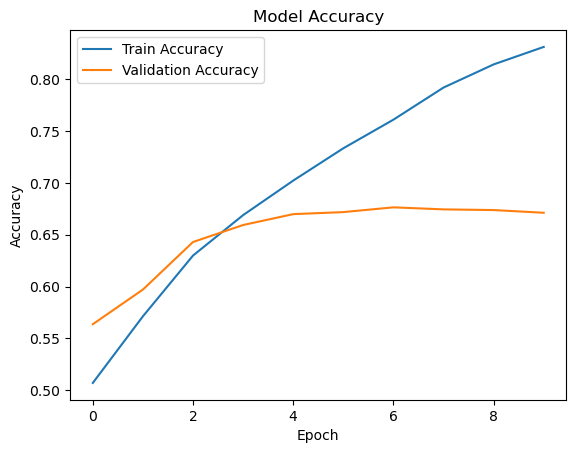

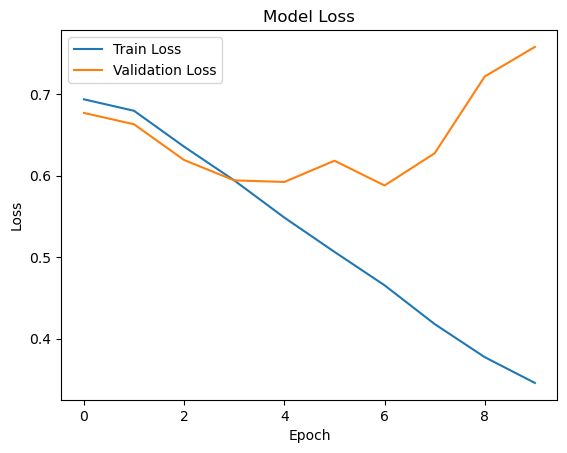

In [18]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Test the Model on the Test Set

In [19]:
# Load the best saved model
best_model = load_model("model/best_model.h5")


# Evaluate on test set
loss, accuracy = best_model.evaluate(test_dataset, verbose=0)
print(f"✅ Test Accuracy: {accuracy:.4f}")


✅ Test Accuracy: 0.6660


### Inference Function for Custom Input

In [20]:
# Inferencing function
def predict_sentiment(text):
    # Clean input text
    cleaned = clean_text(text)
    
    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=100, padding='post', truncating='post')

    # Predict
    prediction = best_model.predict(padded)[0][0]
    sentiment = "Positive Review" if prediction > 0.5 else "Negative Review"
    
    print(f"Input: {text}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {prediction:.2f})")
    return sentiment


In [21]:
# Inferencing
predict_sentiment("I absolutely loved the product! Totally worth the money.")
predict_sentiment("Terrible quality. It broke after two days.")
predict_sentiment("It's okay, not the best, not the worst.")


1/1 [==============================] - 1s 1s/step
Input: I absolutely loved the product! Totally worth the money.
Predicted Sentiment: Positive Review (Confidence: 0.74)
1/1 [==============================] - 0s 50ms/step
Input: Terrible quality. It broke after two days.
Predicted Sentiment: Negative Review (Confidence: 0.11)
1/1 [==============================] - 0s 41ms/step
Input: It's okay, not the best, not the worst.
Predicted Sentiment: Negative Review (Confidence: 0.09)


'Negative Review'